# Canny Edge Detection

## Import Library

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

## Load Image

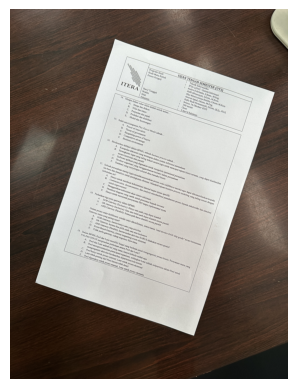

In [4]:
image_path = os.path.join(os.getcwd(), 'data', 'img_photo_docs.JPG')
img_data = cv2.imread(image_path)

# preview using matplotlib (jangan lupa konversi BGR ke RGB)
plt.imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 1. Pre-processing

In [34]:
print(f"Original Image size): {img_data.shape}")

ratio = img_data.shape[0] / 500.0
resized_img = cv2.resize(img_data, (int(img_data.shape[1] / ratio), 500))
resize_img_gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
res_gray_blur = cv2.GaussianBlur(resize_img_gray, (5, 5), 0)


Original Image size): (4032, 3024, 3)


## Preview Pre-processing

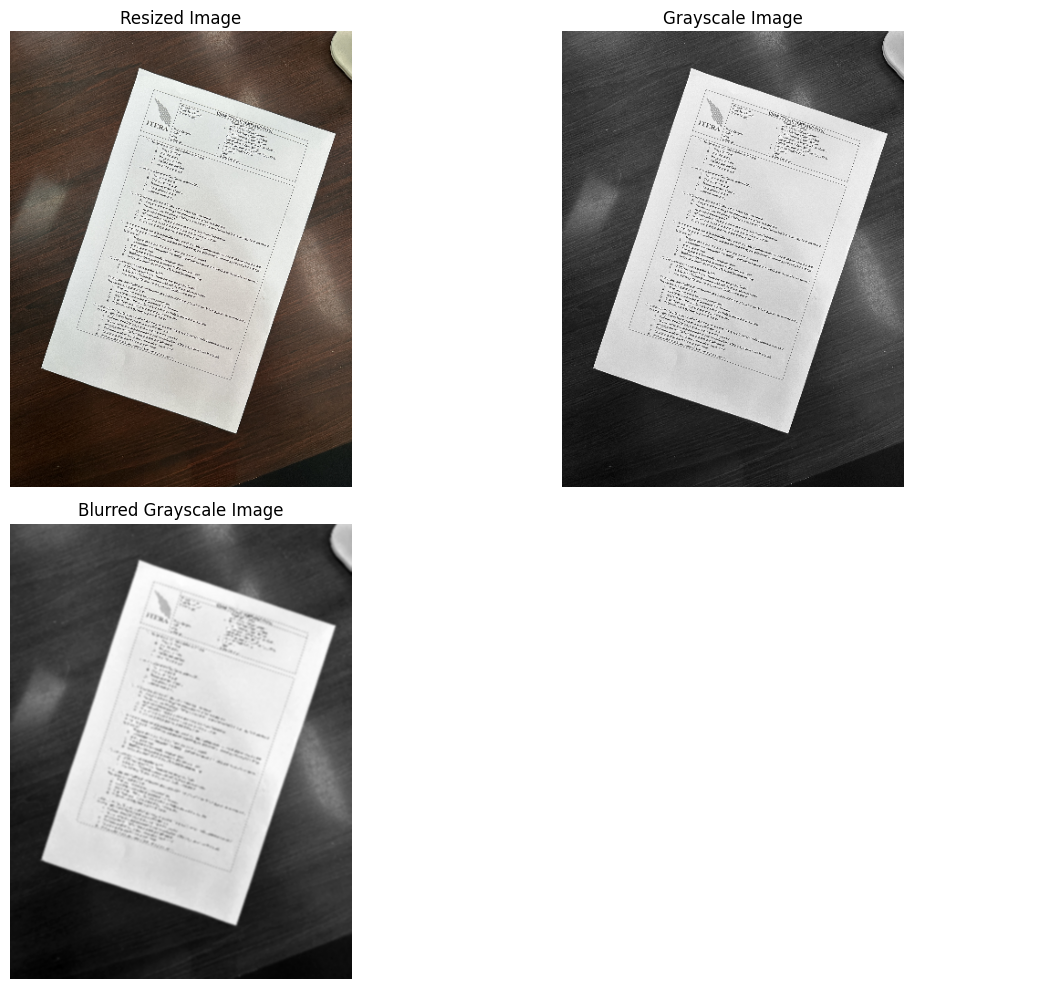

In [35]:

# Create subplot untuk menampilkan perubahan image
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original resized image
axes[0, 0].imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Resized Image')
axes[0, 0].axis('off')

# Grayscale image
axes[0, 1].imshow(resize_img_gray, cmap='gray')
axes[0, 1].set_title('Grayscale Image')
axes[0, 1].axis('off')

# Blurred grayscale image
axes[1, 0].imshow(res_gray_blur, cmap='gray')
axes[1, 0].set_title('Blurred Grayscale Image')
axes[1, 0].axis('off')

# Hide the last subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# 2. Canny Detection

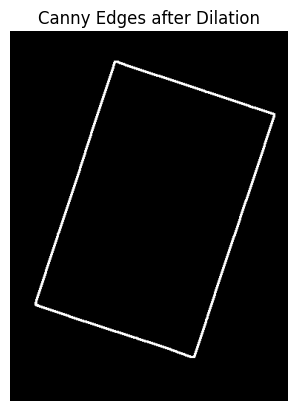

In [41]:
edge = cv2.Canny(res_gray_blur, 200, 600)

# Dilatasi
kernel = np.ones((3, 3), np.uint8)
edged = cv2.dilate(edge, kernel, iterations=1)

plt.imshow(edged, cmap='gray')
plt.title('Canny Edges after Dilation')
plt.axis('off')
plt.show()

# 3. Find Contours 

In [42]:
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# print(f"Isi dari: {contours[:5]}")  # Menampilkan 10 kontur pertama untuk referensi
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

### Cari Titik Sudut

In [43]:
document_contour = None

for i, contour in enumerate(contours):
    peri = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    
    # Buat titik approximation
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
    print(f"Contour #{i}: Area = {area}, Perimeter = {peri}, Vertices = {len(approx)}")
    
    if len(approx) == 4 and area > 10000:
        document_contour = approx
        print(f"Document contour found with area: {area}")
        break

Contour #0: Area = 79767.5, Perimeter = 1240.8742331266403, Vertices = 4
Document contour found with area: 79767.5


### Preview Contour dari Dokumen

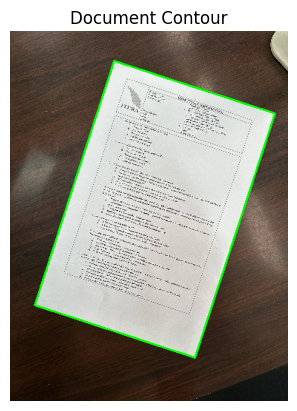

In [44]:
contour_image = resized_img.copy()
cv2.drawContours(contour_image, [document_contour], -1, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Document Contour')
plt.axis('off')
plt.show()

# 4. Transformasi Perspektif

In [49]:
pts = document_contour.reshape(4, 2) * ratio
rect = np.zeros((4, 2), dtype="float32")
s = pts.sum(axis=1)

In [51]:
rect[0] = pts[np.argmin(s)] # kiri atas
rect[2] = pts[np.argmax(s)] # kanan bawah
diff = np.diff(pts, axis=1)
rect[1] = pts[np.argmin(diff)] # kanan atas
rect[3] = pts[np.argmax(diff)] # kiri bawah

print(f"Original Image size): {img_data.shape}")
print(f"Document corners (after scaling): {rect}")

Original Image size): (4032, 3024, 3)
Document corners (after scaling): [[1128.96   322.56 ]
 [2878.848  895.104]
 [2007.936 3556.224]
 [ 266.112 2983.68 ]]


In [52]:
tl, tr, br, bl = rect
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))

print(f"maxWidth: {maxWidth}, maxHeight: {maxHeight}")

maxWidth: 1841, maxHeight: 2800


In [53]:
dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]
], dtype="float32")

print(f"dst: {dst}")

dst: [[   0.    0.]
 [1840.    0.]
 [1840. 2799.]
 [   0. 2799.]]


In [54]:
# Transformasi Perspektif

M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(img_data, M, (maxWidth, maxHeight))

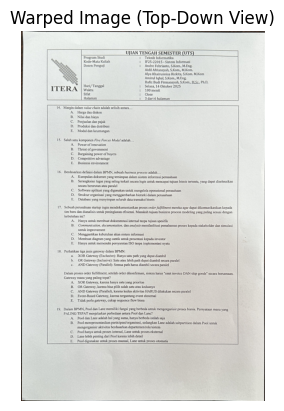

In [58]:
# Preview hasil transformasi perspektif
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('Warped Image (Top-Down View)')
plt.axis('off')
output_path = os.path.join(os.getcwd(), 'scanned_document.jpg')
cv2.imwrite(output_path, warped)
plt.show()


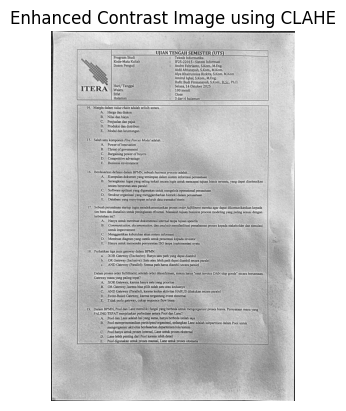

In [60]:
warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

threshold = cv2.adaptiveThreshold(warped_gray, 255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY,
                                        11,
                                        2)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(warped_gray)

plt.imshow(enhanced_image, cmap='gray')
plt.title('Enhanced Contrast Image using CLAHE')
plt.axis('off')
plt.show()

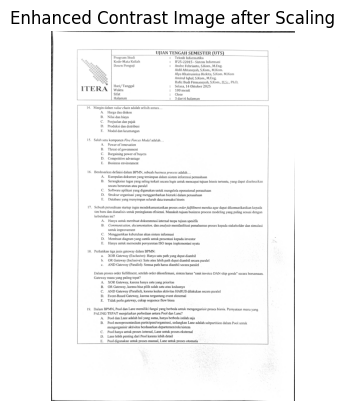

True

In [72]:
enhanced_image_contrast = cv2.convertScaleAbs(enhanced_image, alpha=1.3, beta=63)

plt.imshow(enhanced_image_contrast, cmap='gray')
plt.title('Enhanced Contrast Image after Scaling')
plt.axis('off')
plt.show()

# save image final
final_output_path = os.path.join(os.getcwd(), 'final_enhanced_document_contrast.jpg')
cv2.imwrite(final_output_path, enhanced_image_contrast)

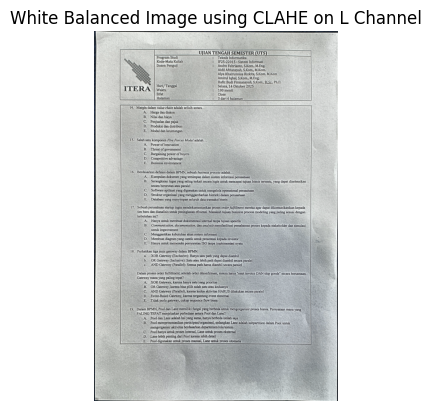

In [67]:
lab_color = cv2.cvtColor(warped, cv2.COLOR_BGR2LAB)
l_channel, a_channel, b_channel = cv2.split(lab_color)
l_channel = clahe.apply(l_channel)
enhanced_lab_img = cv2.merge((l_channel, a_channel, b_channel))
white_balanced_img = cv2.cvtColor(enhanced_lab_img, cv2.COLOR_LAB2BGR)

plt.imshow(white_balanced_img)
plt.title('White Balanced Image using CLAHE on L Channel')
plt.axis('off')
plt.show()

In [66]:
# Save final image
final_output_path = os.path.join(os.getcwd(), 'final_enhanced_document.jpg')
cv2.imwrite(final_output_path, white_balanced_img)

True